In [1]:
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torchvision

from torchsummary import summary

In [3]:
resnet18 = torchvision.models.resnet18(pretrained=True)

In [4]:
resnet18.cuda()
summary(resnet18, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [28]:
for p in resnet18.named_parameters():
    print(p[0])

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [289]:
Y = resnet18.layer4[1].conv1.weight.data.detach().cpu().clone().numpy()
Y = Y.reshape(512,512,9).transpose([2,0,1])
Y = np.transpose(Y, [1,2,0])

In [290]:
Y.shape

(512, 512, 9)

In [282]:
R = 50
R1, R2 = 30,30

In [297]:
core.shape

(90, 90, 9)

In [302]:
U = np.diag(np.ones(90))[:,:R1]
V = np.diag(np.ones(90))[:,:R2]
A = np.random.randn(R1,R)
B = np.random.randn(R2,R)
C = np.random.randn(9,R)

#Y_restored = np.transpose(tl.kruskal_to_tensor((np.ones(R), (U@A, V@B, C))), [0,1,2])

#print("Random tensors. Norm is", np.linalg.norm(Y-Y_restored))

In [307]:
Y1 = tl.unfold(core,0)
for i in range(20):
    #print("Relative Norm is", np.linalg.norm((U@A @ (tl.tenalg.khatri_rao([C, V@B])).T) - Y1)/\
         # np.linalg.norm(Y1))
    A = U.T @ tl.unfold(core,0) @ (tl.tenalg.khatri_rao([C, V@B])) @ np.linalg.inv(C.T@C * (B.T@B))
    Q = tl.unfold(core,0) @ (tl.tenalg.khatri_rao([C, V@B]))@ np.linalg.inv((C.T@C * (B.T@B))) @\
        tl.tenalg.khatri_rao([C, V@B]).T @ tl.unfold(core,0).T

    eigvals, eigvecs = np.linalg.eigh(Q)
    indices = np.argsort(np.abs(eigvals))[-R1:]
    
    U = eigvecs[:,indices]
    
    B = V.T @ tl.unfold(core,1) @ (tl.tenalg.khatri_rao([C, U@A])) @ np.linalg.inv(C.T@C * (A.T@A))
    """
    R_ = tl.unfold(core,1) @ tl.tenalg.khatri_rao([C, U@A]) @ np.linalg.inv(C.T@C * (A.T@A)) @ \
        tl.tenalg.khatri_rao([C, U@A]).T@tl.unfold(core,1).T
    eigvals, eigvecs = np.linalg.eig(R_)
    indices = np.argsort(np.abs(eigvals))[-R2:]
    V = eigvecs[:,indices]
    
    C = tl.unfold(core,2) @ (tl.tenalg.khatri_rao([U@A, V@B])) @ np.linalg.inv(B.T@B * (A.T@A))
    #C[C < 0] = 0
    
    """
    
   

    
    
    print("Relative Norm is", np.linalg.norm((U@A @ (tl.tenalg.khatri_rao([C, V@B])).T) - Y1)/\
          np.linalg.norm(Y1))

Relative Norm is 18.190965891528155
Relative Norm is 55.72791856522463
Relative Norm is 36.56090282025632
Relative Norm is 33.93444784652989
Relative Norm is 42.87015802962677
Relative Norm is 227.06430247442577
Relative Norm is 38.463958262867614
Relative Norm is 75.43506778073713
Relative Norm is 54.737510400389006
Relative Norm is 60.43710728862648
Relative Norm is 27.575896838148743
Relative Norm is 46.812581269660406
Relative Norm is 37.49252651074015
Relative Norm is 14.538573546039027
Relative Norm is 106.04868299273694
Relative Norm is 19.562351070977858
Relative Norm is 25.264579092814405
Relative Norm is 35.41485944195529
Relative Norm is 33.11529809550182
Relative Norm is 2095.3395462344997


# TKD-CPD

In [5]:
from tensorly.decomposition import partial_tucker

In [6]:
Y = resnet18.layer4[1].conv1.weight.data.detach().cpu().clone().numpy()
Y = Y.reshape(512, 512, 9)
Y = Y.transpose((2, 1, 0))

In [7]:
Y.shape

(9, 512, 512)

In [8]:
def conduct_compression(Y, r1,r2,R):
    core, factors = partial_tucker(Y, 
                                   modes=[1,2],
                                   ranks=[r1,r2],
                                   n_iter_max=200, 
                                   tol=1e-6)
    np.save(f"core_{r1}_{r2}_{R}", core)
    for i in range(len(factors)):
        np.save(f"factor_{i}_{r1}_{r2}_{R}" , factors[i])
    core_weights, core_factors = tl.decomposition.parafac(core,
                             rank=R, 
                             n_iter_max=5000,
                             tol=1e-7)
    np.save(f"core_weights_{r1}_{r2}_{R}", core_weights)
    for i in range(2):
        np.save(f"core_factor_{i}_{r1}_{r2}_{R}", core_factors[i])
    restored_core = tl.kruskal_to_tensor((core_weights, core_factors))

    np.linalg.norm(core-restored_core)/np.linalg.norm(core)

    restored_conv = np.zeros_like(Y)
    restored_conv = np.zeros_like(Y)
    for i in range(9):
        restored_conv[i] = tl.tucker_to_tensor((restored_core[i], factors))

    return np.linalg.norm(restored_conv-Y)/np.linalg.norm(Y)

In [355]:
norms_aggr = {}

In [356]:
norms = {}
for R in [100, 120, 150, 180, 210, 240, 250, 280, 300, 330, 380, 400]:
    norm = conduct_compression(Y, 90,90,R)
    norms[R] = norm
norms_aggr["90 90"] = norqms

In [357]:
for r1 in (30,60,90):
    print()
    print("r1 is", r1, end="")
    for r2 in (30,60,90):
        print(r2, end = " ")
        if r1 == 90 and r2 == 90:
            pass
        else:
            for R in [100, 120, 150, 180, 210, 240, 250, 280, 300, 330, 380, 400]:
                norm = conduct_compression(Y, r1, r2,R)
                norms[R] = norm
            norms_aggr[str(r1) +" "+str(r2)] = norms


r1 is 3030 

/home/egor/egor_torch/lib/python3.6/site-packages/tensorly/backend/__init__.py:161: RuntimeWarning: invalid value encountered in sqrt
  return _get_backend_method(name)(*args, **kwargs)
/home/egor/egor_torch/lib/python3.6/site-packages/tensorly/backend/core.py:752: UserWarning: Trying to compute SVD with n_eigenvecs=280, which is larger than max(matrix.shape)=270. Setting n_eigenvecs to 270
  'n_eigenvecs to {1}').format(n_eigenvecs, max_dim))
/home/egor/egor_torch/lib/python3.6/site-packages/tensorly/decomposition/_cp.py:319: RuntimeWarning: overflow encountered in multiply
  pseudo_inverse = pseudo_inverse*tl.dot(tl.conj(tl.transpose(factor)), factor)
/home/egor/egor_torch/lib/python3.6/site-packages/tensorly/backend/core.py:752: UserWarning: Trying to compute SVD with n_eigenvecs=300, which is larger than max(matrix.shape)=270. Setting n_eigenvecs to 270
  'n_eigenvecs to {1}').format(n_eigenvecs, max_dim))
/home/egor/egor_torch/lib/python3.6/site-packages/tensorly/backend/core.py:7

60 90 
r1 is 6030 60 90 
r1 is 9030 60 

KeyboardInterrupt: 

In [342]:
vals = []
for i in list(norms.keys()):
    vals.append(norms[i])

In [343]:
import matplotlib.pyplot as plt
%matplotlib inline

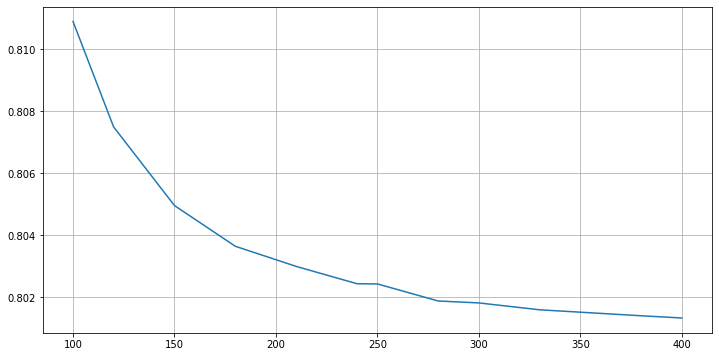

In [344]:
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(list(norms.keys()),vals )

In [359]:
def reconstruct(r1,r2,R):
    

{100: 0.8373229,
 120: 0.83559126,
 150: nan,
 180: 0.88043,
 210: nan,
 240: nan,
 250: nan,
 280: nan,
 300: nan,
 330: nan,
 380: nan,
 400: nan}

In [9]:
r1,r2,R=90,60,150

In [14]:
#np.load("")
core = np.load(f"./decompositions/core_{r1}_{r2}_{R}.npy")
factors = []
for i in range(2):
        factors.append(np.load(f"./decompositions/factor_{i}_{r1}_{r2}_{R}.npy"))
        
core_weights = np.load(f"./decompositions/core_weights_{r1}_{r2}_{R}.npy")
core_factors = []
for i in range(2):
    core_factors.append(np.load(f"./decompositions/core_factor_{i}_{r1}_{r2}_{R}.npy"))

In [371]:
factors[0].shape

(512, 90)

In [364]:
r1,r2

(90, 60)

In [365]:
R

150